# 0.0 IMPORTS

In [1]:
import os
import sys
import warnings

import pandas            as pd
import numpy             as np
import seaborn           as sns
import sklearn.metrics   as metrics
import matplotlib.pyplot as plt


from IPython.display         import Image
from IPython.core.display    import HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import IsolationForest
from sklearn.metrics         import classification_report, confusion_matrix, accuracy_score



## 0.1. Helper Functions

In [2]:
# função para remover os warnings:
def remove_warnings():
    if not sys.warnoptions:
        warnings.simplefilter('ignore')
        
        
        
# função para carregar configurações específicas:

def my_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 11]
    plt.rcParams['font.size'] = 24
        
    # notebook settings
    display(HTML('<style>.container{width:85% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
        
    # seaborn settings
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.5)

    
def momentos_estatisticos(num_attributes):
    # Central Tendency: Mean, Median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion: - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(np.min)).T
    d3 = pd.DataFrame(num_attributes.apply(np.max)).T
    d4 = pd.DataFrame(num_attributes.apply(np.max) - num_attributes.apply(np.min) ).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

    # concatenate
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return m

In [3]:
# chamar algumas funções padrão:
remove_warnings()
my_settings()

## 0.2. Load Data

In [4]:
# mudar o diretório
os.chdir('E:\\Projetos\\repos-de-projetos\\deteccao_de_fraude\\data')

# carregar os dados:
df_raw = pd.read_csv('creditcard.csv', low_memory=False)

In [5]:
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


# 1.0 DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [7]:
# Dimensão dos dados:

print('Number of Rows: {}'.format(df1.shape[0]))
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 284807
Number of Cols: 31


## 1.2. Data Info

In [8]:
# informações sobre o data frame:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 1.3. Data Types

In [9]:
# Checagem dos tipos dos dados:
df1.dtypes.value_counts()

float64    30
int64       1
dtype: int64

## 1.4. Check NAs

In [10]:
# checagem de valores faltantes (missing values):

if df1.isnull().values.any() == False:
    print('\n Não existem valores faltantes')
else:
    print('\n Existem valores faltantes')
    
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum()/df1.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


 Não existem valores faltantes


,Total,Percent
Time,0,0.00
V16,0,0.00
Amount,0,0.00
V28,0,0.00
V27,0,0.00
V26,0,0.00
V25,0,0.00
V24,0,0.00
V23,0,0.00
V22,0,0.00


In [11]:
# Sumarizar os resultados dos NAs, se houver:
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum()/df1.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Total,Percent
Time,0,0.00
V16,0,0.00
Amount,0,0.00
V28,0,0.00
V27,0,0.00
V26,0,0.00
V25,0,0.00
V24,0,0.00
V23,0,0.00
V22,0,0.00


## 1.5. Check Target Balance

In [12]:
# Checagem do balanceamento da variável target, variável 'Class':

print(f'\nTotal de fraudes: {round(df1[df1["Class"] == 1].shape[0]/df1.shape[0]*100, 3)}%')


Total de fraudes: 0.173%


## 1.6. Descriptive Statistical

In [13]:
# Checagem estatitica dos dados:
print('\n Lembrando que as variáveis V1, V2, ..., V28 são oriundas de um PCA, logo a sua análise descritiva perde em sentido.')

momentos_estatisticos(df1.select_dtypes(include=['int64', 'float64']))




 Lembrando que as variáveis V1, V2, ..., V28 são oriundas de um PCA, logo a sua análise descritiva perde em sentido.


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Time,0.00,172792.00,172792.00,94813.86,84692.00,47488.06,-0.04,-1.29
1,V1,-56.41,2.45,58.86,0.00,0.02,1.96,-3.28,32.49
2,V2,-72.72,22.06,94.77,0.00,0.07,1.65,-4.62,95.77
3,V3,-48.33,9.38,57.71,-0.00,0.18,1.52,-2.24,26.62
4,V4,-5.68,16.88,22.56,0.00,-0.02,1.42,0.68,2.64
5,V5,-113.74,34.80,148.54,-0.00,-0.05,1.38,-2.43,206.90
6,V6,-26.16,73.30,99.46,0.00,-0.27,1.33,1.83,42.64
7,V7,-43.56,120.59,164.15,-0.00,0.04,1.24,2.55,405.61
8,V8,-73.22,20.01,93.22,-0.00,0.02,1.19,-8.52,220.59
9,V9,-13.43,15.59,29.03,-0.00,-0.05,1.10,0.55,3.73


# 2.0 FEATURE ENGINEERING

## 2.1. Mind Map Hypothesis

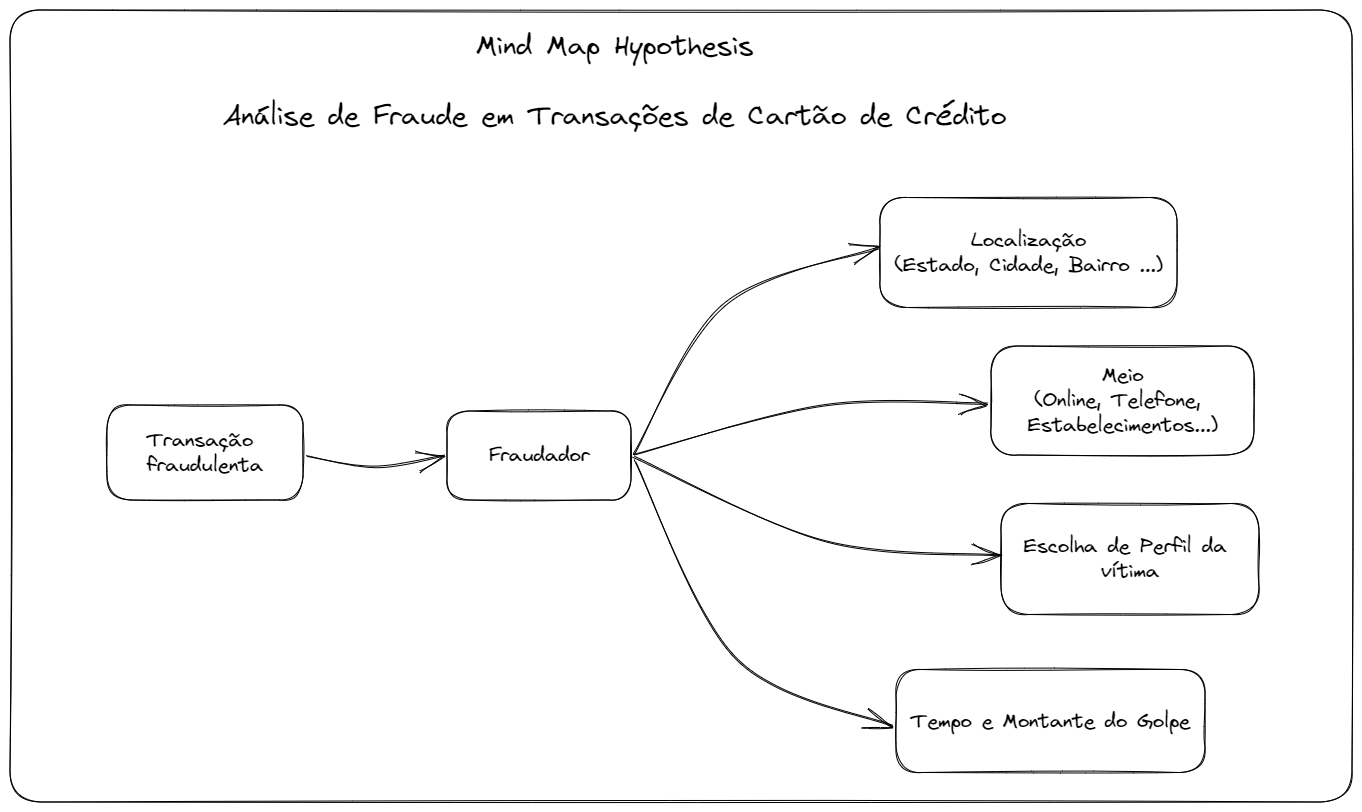

In [14]:
os.chdir('E:\\Projetos\\repos-de-projetos\\deteccao_de_fraude\\images')
Image(data = 'mind-map.png', )

## 2.1. Criando as Hipóteses

#### Observação:

Como a maioria das features são oriundas de um PCA, devido a anonimização os dados, a criação de hipóteses fica limitada a features conhecidas, como o tempo e montante financeiro.

### 2.2.1 Hipóteses Sobre Tempo e Montante



**1.** As transações fraudulentas são financeiramente menores do que as operações não fraudulentas.

**2.** As fraudes ocorrem em períodos específicos.

**3.** As transações fraudulentas de maior valor ocorrem durante os períodos de maior transação.


# 3.0 EXPLORATORY DATA ANALYSIS (EDA)

In [15]:
df2 = df1.copy()

## 3.1. Análise Univariada

### 3.1.1. Distribuições de Probabilidade entre as diferentes Classes

<Figure size 2000x1000 with 0 Axes>

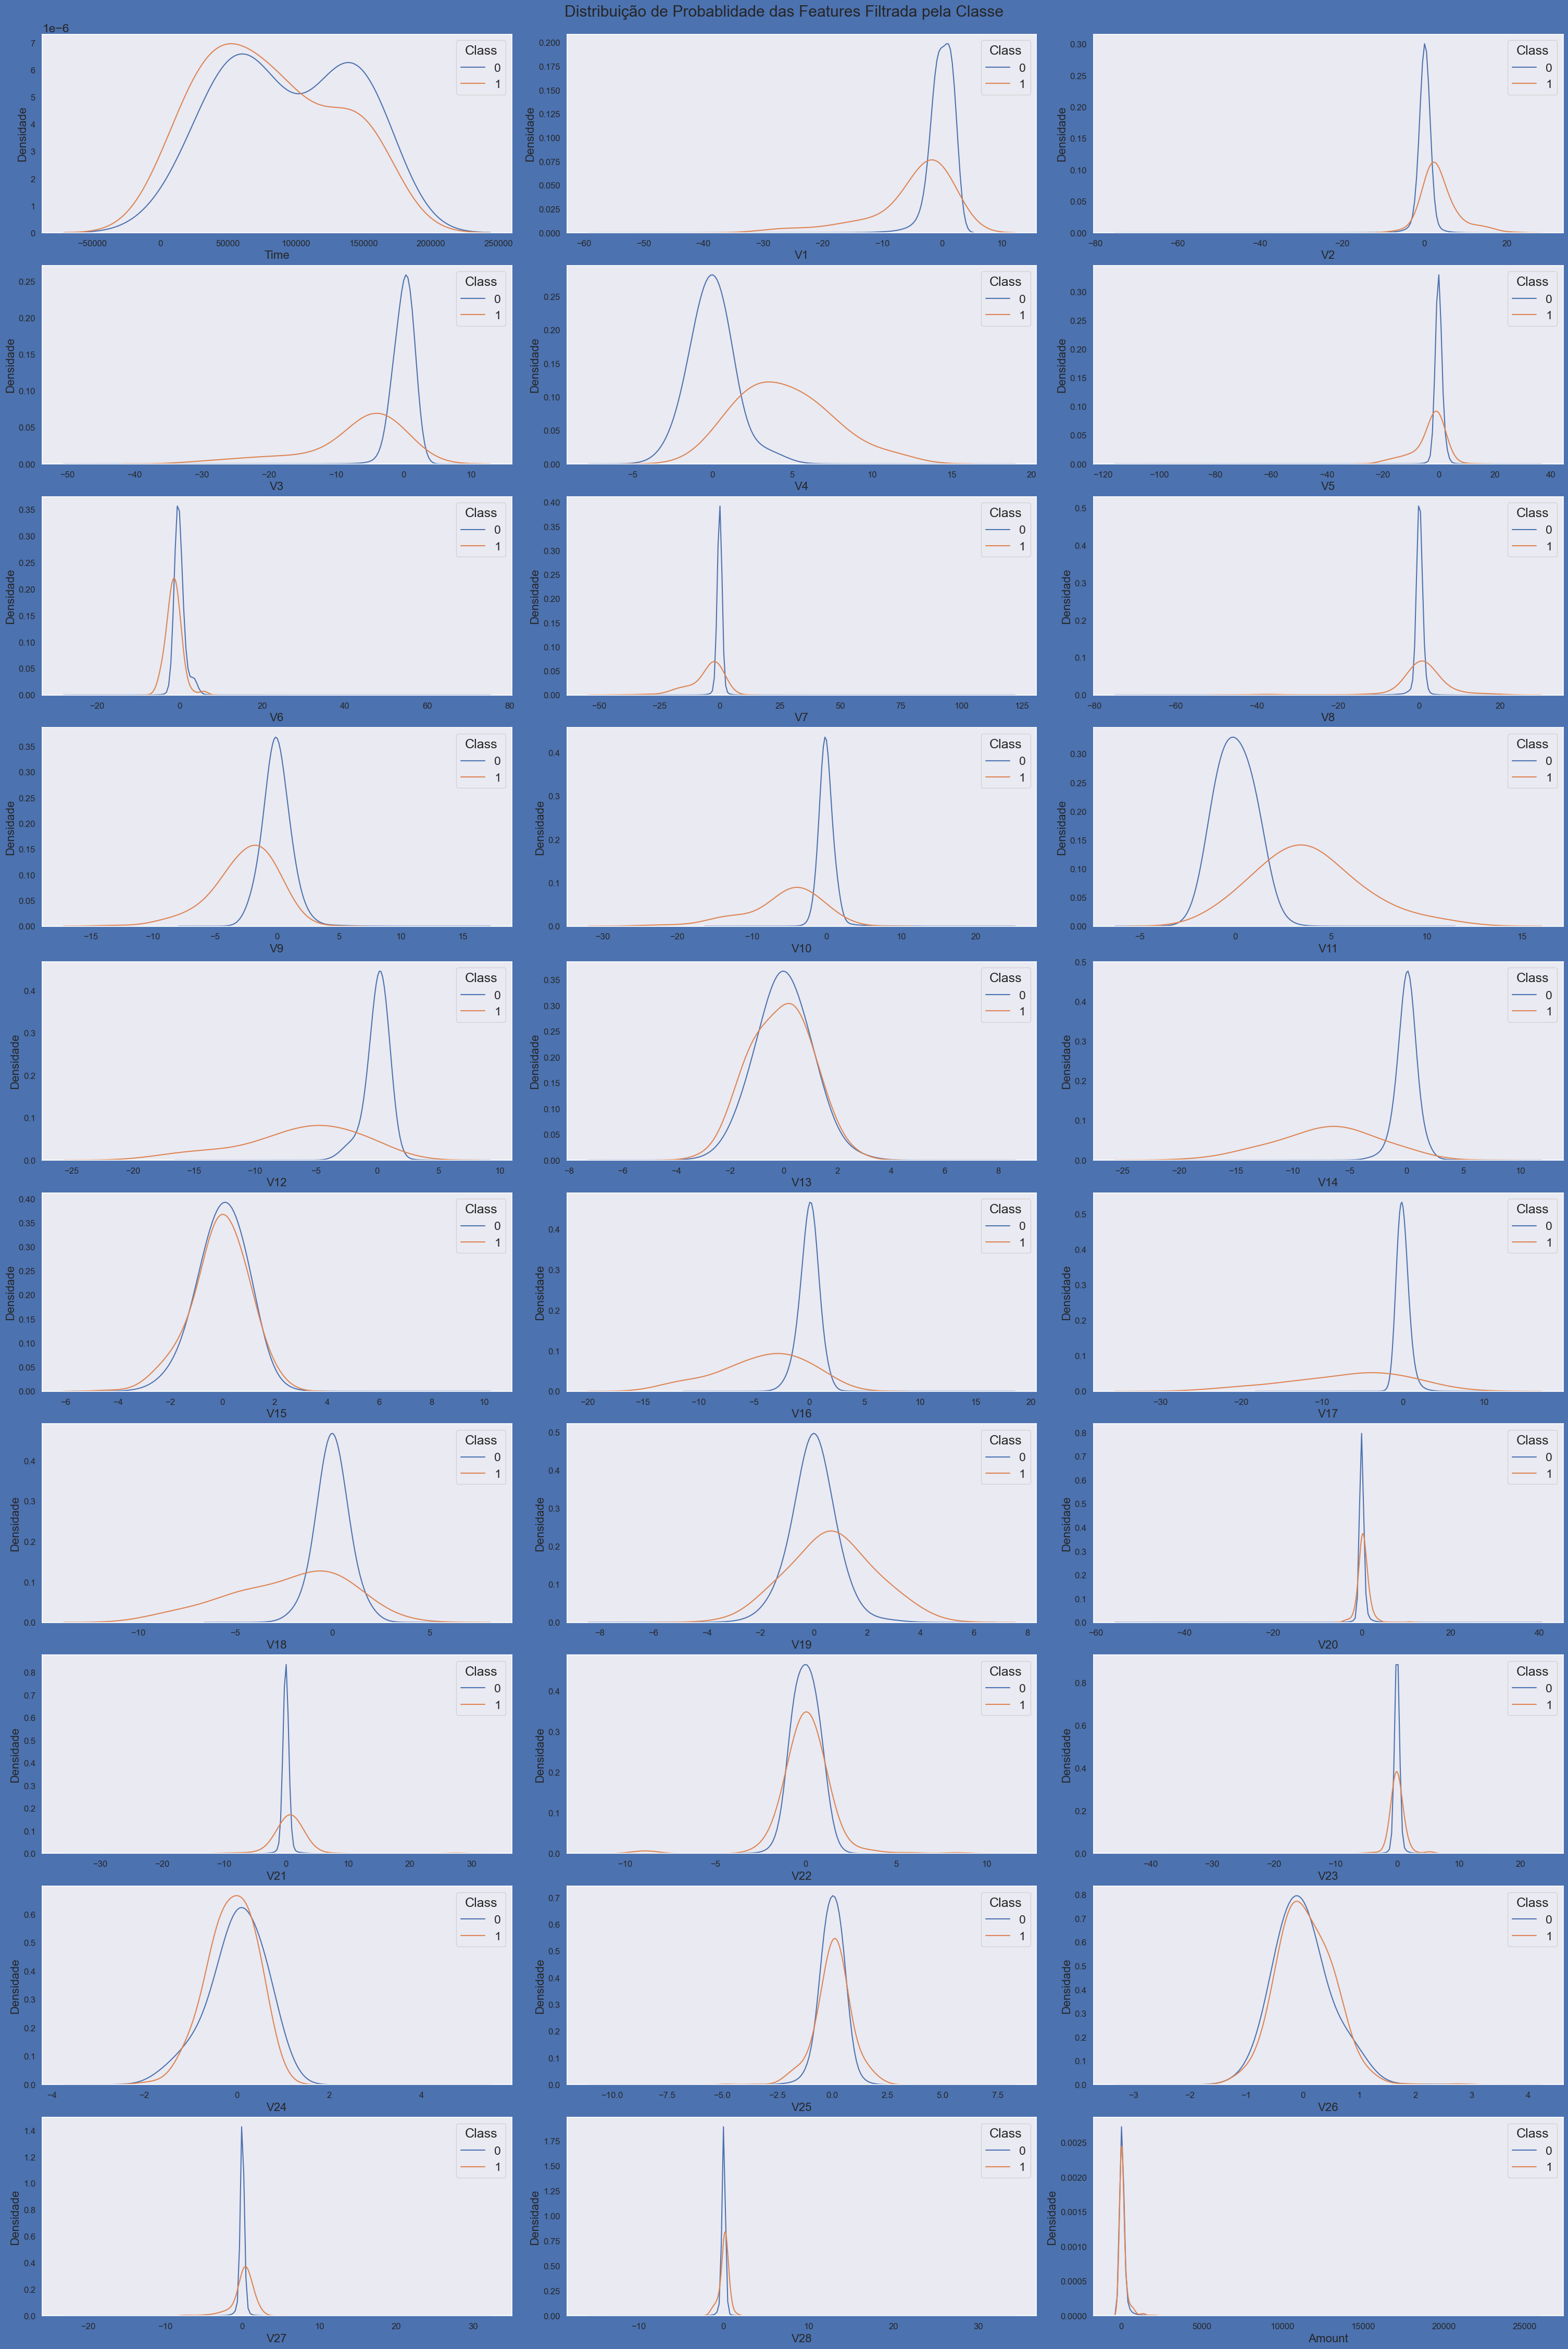

In [16]:
# Plotar a distribuição das features:

# criar uma lista com o nome das features:
var = list(df2.columns.values)

# Remove o target da lista:
var.remove("Class")

# dividir as classes
t0 = df2.loc[df2['Class'] == 0]
t1 = df2.loc[df2['Class'] == 1]

plt.figure()
fig, ax = plt.subplots(10,3,figsize=(30,45), facecolor='b', layout="constrained");
fig.suptitle('Distribuição de Probablidade das Features Filtrada pela Classe')

i = 0
for feature in var:
    i += 1
    plt.subplot(10,3,i)
    
    sns.kdeplot(t0[feature], bw=0.5, hue=df2['Class'])
    sns.kdeplot(t1[feature], bw=0.5, hue=df2['Class'])
        
    plt.xlabel(feature, fontsize=16)
    plt.ylabel("Densidade", fontsize=16)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid()
    
plt.show();

O gráfico acima nos mostra que algumas features apresentam uma boa seletividade em termos de distribuição de probabilidade, vejamos abaixo:

| Features | Característica  | Possível Importância |
| :--- | :---: | ---: |
| V4, V11 | Distribuições Separadas entre as classes | **Alta** |
| V12, V14, V18 | Distribuições parcialmente separadas entre as classes | *Média* |
| V1, V2, V3 , V10 | Distribuições distintas entre as classes | *Média* |
| V15, V25, V26, V28 | Distribuições semelhantes entre as classes | Baixa |





Outro detalhe sobre as distribuições é que as transações legítimoas, em boa parte, apresentam as features centradas em zero, já as transações fraudulentas apresentam uma distribuição mais assimétrica.



### H1.  As transações fraudulentas são financeiramente menores do que as operações não fraudulentas.

**FALSO.**  As transações fraudulentas são financeiramente maiores *na média* do que as operações não fraudulentas.

In [17]:
print('métricas para operações verdadeiras')
df2[df2['Class'] == 0]['Amount'].describe()

métricas para operações verdadeiras


count   284315.00
mean        88.29
std        250.11
min          0.00
25%          5.65
50%         22.00
75%         77.05
max      25691.16
Name: Amount, dtype: float64

In [18]:
print('métricas para operações fraudulentas')
df2[df2['Class'] == 1]['Amount'].describe()

métricas para operações fraudulentas


count    492.00
mean     122.21
std      256.68
min        0.00
25%        1.00
50%        9.25
75%      105.89
max     2125.87
Name: Amount, dtype: float64

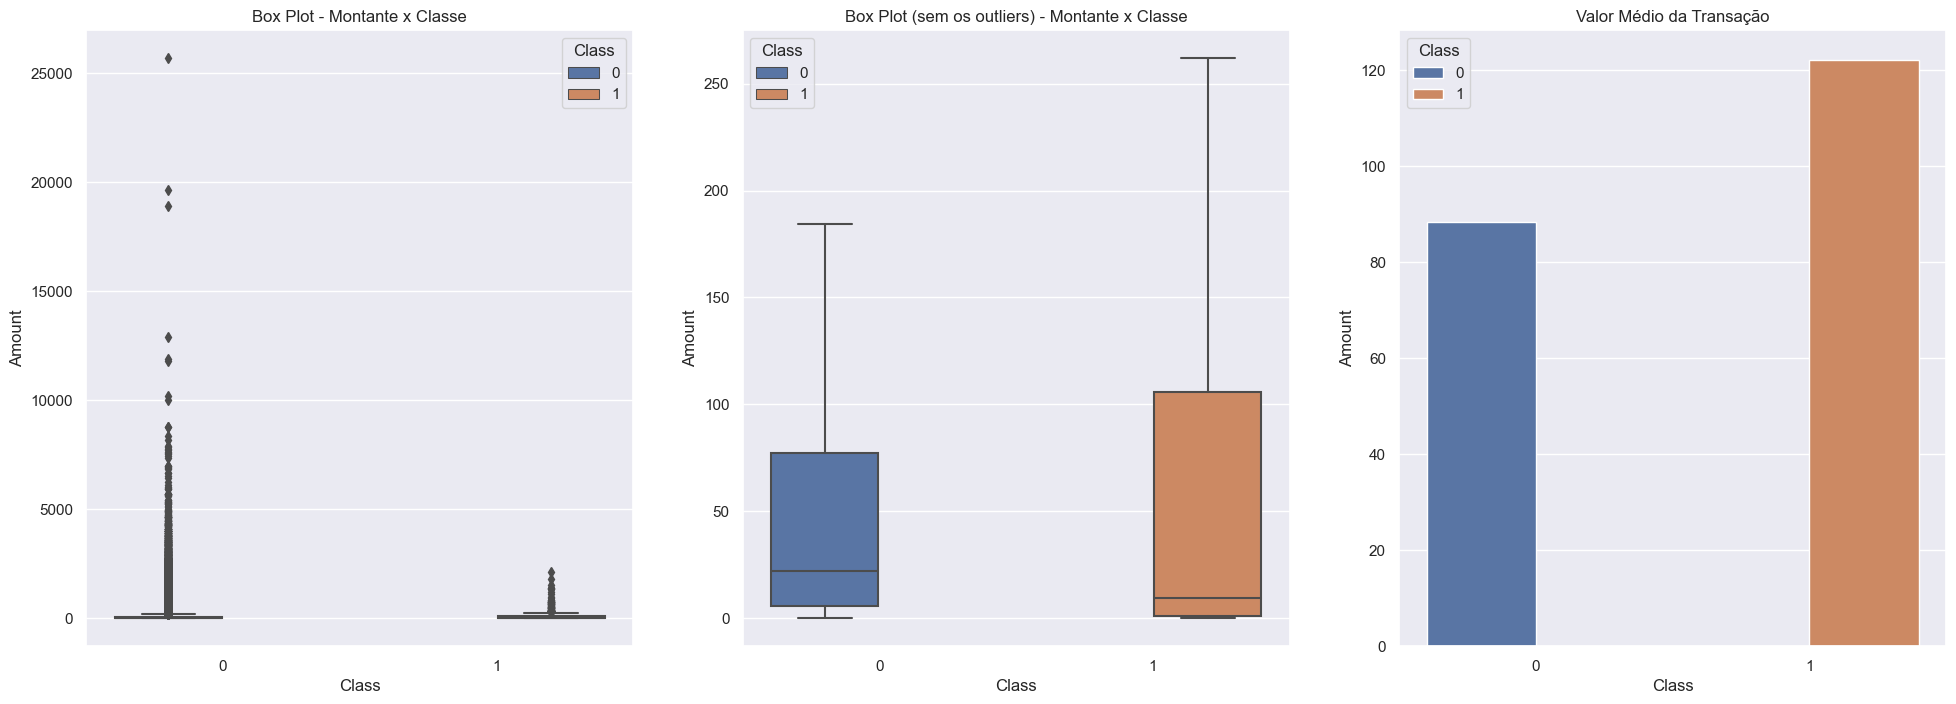

In [19]:
sns.set(rc={'figure.figsize':(24,8)}) # reajustar o fugsize

aux = df2[['Amount','Class']].groupby('Class')['Amount'].mean().reset_index()

# Plot box plot das classes e respectivos montantes:
plt.subplot(1,3,1)
sns.boxplot(x = "Class", y="Amount", data=df1, hue='Class').set_title("Box Plot - Montante x Classe");

plt.subplot(1,3,2)
sns.boxplot(x = "Class", y="Amount",  hue='Class', data=df1, showfliers = False).set_title("Box Plot (sem os outliers) - Montante x Classe");

plt.subplot(1,3,3)
sns.barplot(data= aux, x='Class', y='Amount', hue='Class').set_title('Valor Médio da Transação');



### H2. As fraudes ocorrem em períodos específicos.

**FALSO.** Não há um padrão específico no horário das fraudes, tendo um comportamento semelhante (tendência) as operações válidas.



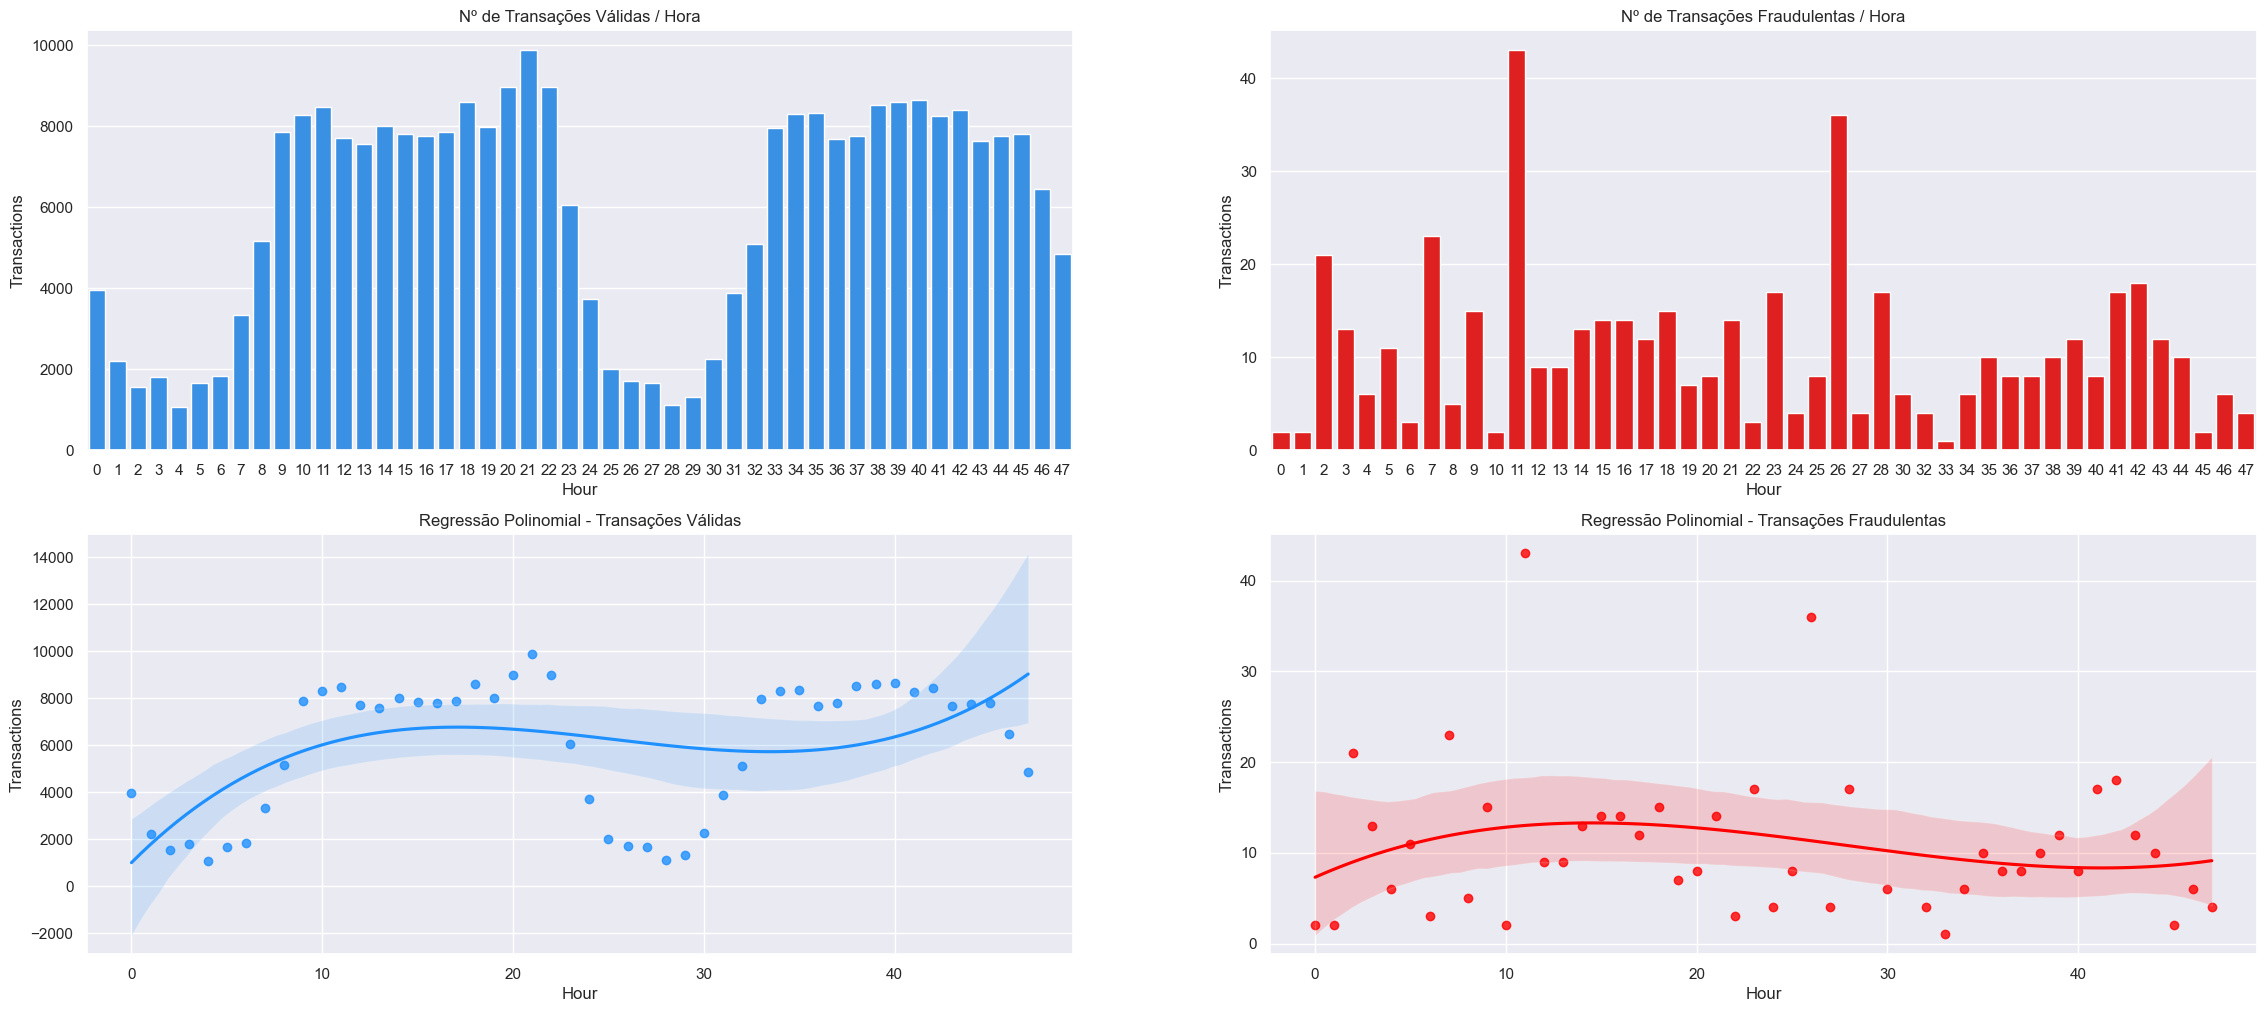

In [20]:
# Criar um dataframe auxiliar:
df_aux = df2.copy()

# Hora que realizada a negociação a partir da primeira negociação:
df_aux['Hour'] = df_aux['Time'].apply(lambda x: np.floor(x / 3600)).astype(int)

# Contabilizar as negociações, montantes e estatísticas por hora em busca de padrões:
df_aux = pd.DataFrame(df_aux.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index())

# Renomear as colunas do DF auxiliar:
df_aux.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']


# ----------------- plotes: --------------------------------------------------------------------------------------------------------------------------------

sns.set(rc={'figure.figsize':(28,12)}) # reajustar o figsize

# plot número de transações verdadeiras por hora:
plt.subplot(2,2,1)
sns.barplot(data=df_aux[df_aux['Class']==0] , y='Transactions', x='Hour', color='dodgerblue').set_title('Nº de Transações Válidas / Hora');

# plot do número de transações fraudulentas por hora:
plt.subplot(2,2,2)
sns.barplot(data=df_aux[df_aux['Class']==1] , y='Transactions', x='Hour', color= 'red').set_title('Nº de Transações Fraudulentas / Hora');

# plotes das regressões polinomiais:
plt.subplot(2,2,3)
sns.regplot(data=df_aux[df_aux['Class']==0] , y='Transactions', x='Hour', order=3, color='dodgerblue').set_title('Regressão Polinomial - Transações Válidas');

plt.subplot(2,2,4)
sns.regplot(data=df_aux[df_aux['Class']==1] , y='Transactions', x='Hour', order=3, color='red').set_title('Regressão Polinomial - Transações Fraudulentas');

### H3.  As transações fraudulentas de maior valor ocorrem durante os períodos de maior transação.

**H3.** Falso. As transações fraudulentas apresentam um maior valor médio maior durante o período de menor volume de transações.

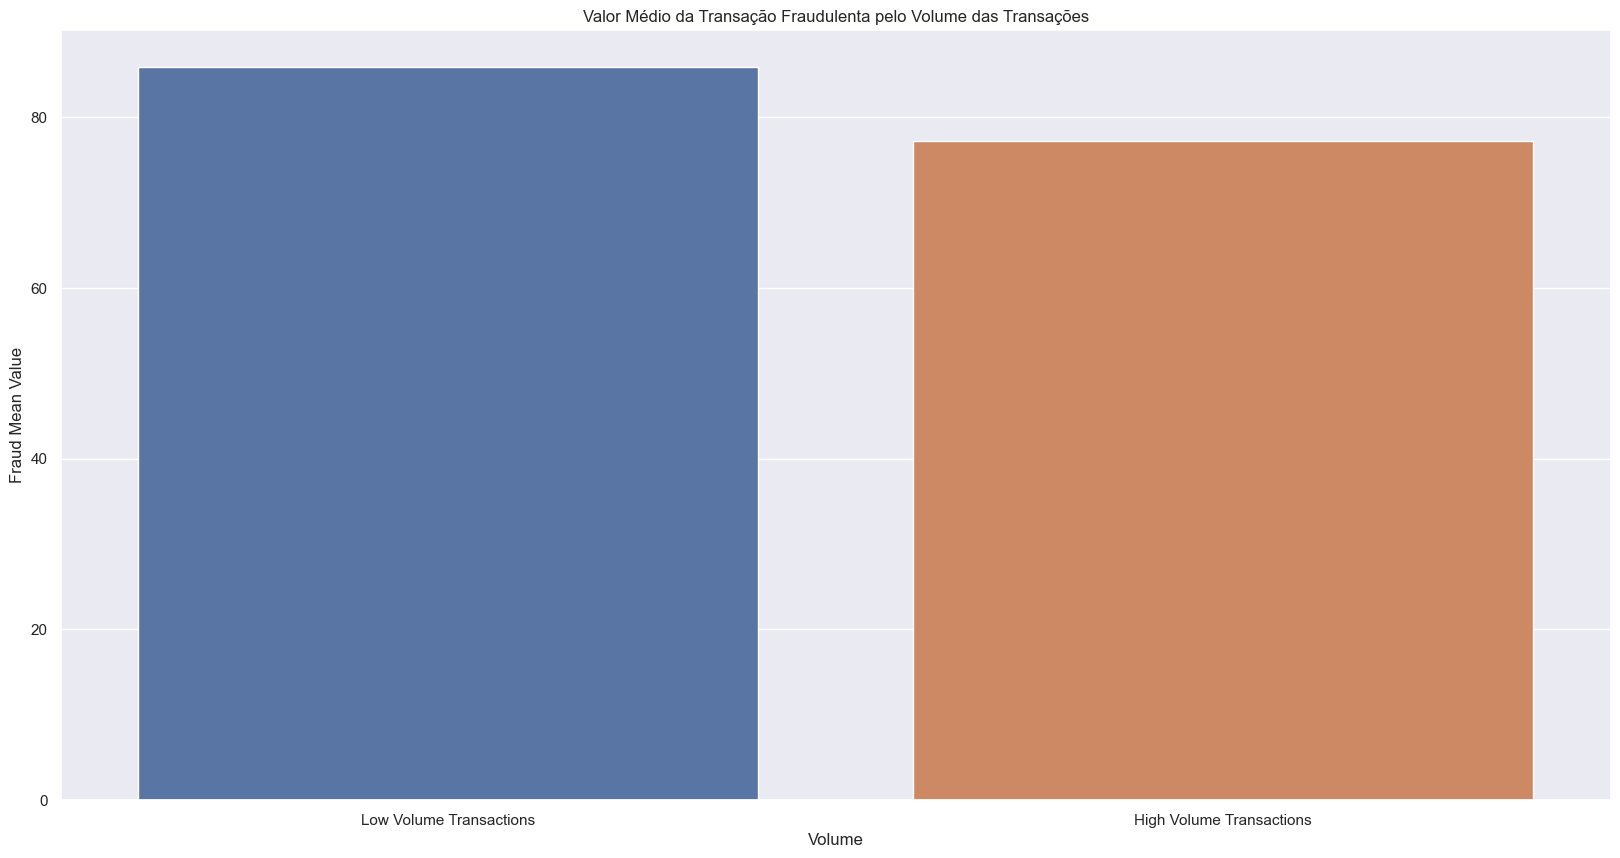

In [21]:
# Criar um dataframe auxiliar:
df_aux = df2.copy()

# Hora que realizada a negociação a partir da primeira negociação:
df_aux['Hour'] = df_aux['Time'].apply(lambda x: np.floor(x / 3600)).astype(int)

# Contabilizar as negociações, montantes e estatísticas por hora em busca de padrões:
df_aux = pd.DataFrame(df_aux.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index())

# Renomear as colunas do DF auxiliar:
df_aux.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']



# Filtrar os dados:
avg_transactions = round(np.mean(df_aux['Transactions']),2)                      # número médio de transações do período
hours_bigvol = df_aux[df_aux['Transactions'] >= avg_transactions]['Hour']        # Horas com número de transações acima da média
  
bigvol_transactions = df_aux[df_aux['Hour'].isin(hours_bigvol)].reset_index()    # df com grande volume de transações
smallvol_transactions = df_aux[~df_aux['Hour'].isin(hours_bigvol)].reset_index() # df com baixo volume de transações

avg_fraud_smallvol = round(np.mean(smallvol_transactions[smallvol_transactions['Class']==1]['Mean']),2)
avg_fraud_bigvol = round(np.mean(smallvol_transactions[bigvol_transactions['Class']==1]['Mean']),2)

# Criar outro df com os valores de interesse:
df_aux2 = pd.DataFrame( {'Volume':['Low Volume Transactions','High Volume Transactions'], 'Fraud Mean Value':[avg_fraud_smallvol, avg_fraud_bigvol]} )


# ----------------- plotes: --------------------------------------------------------------------------------------------------------------------------------

sns.set(rc={'figure.figsize':(20,10)}) # reajustar o figsize
sns.barplot(data=df_aux2, y='Fraud Mean Value', x='Volume').set_title('Valor Médio da Transação Fraudulenta pelo Volume das Transações');


## 3.2. Análise Multivariada

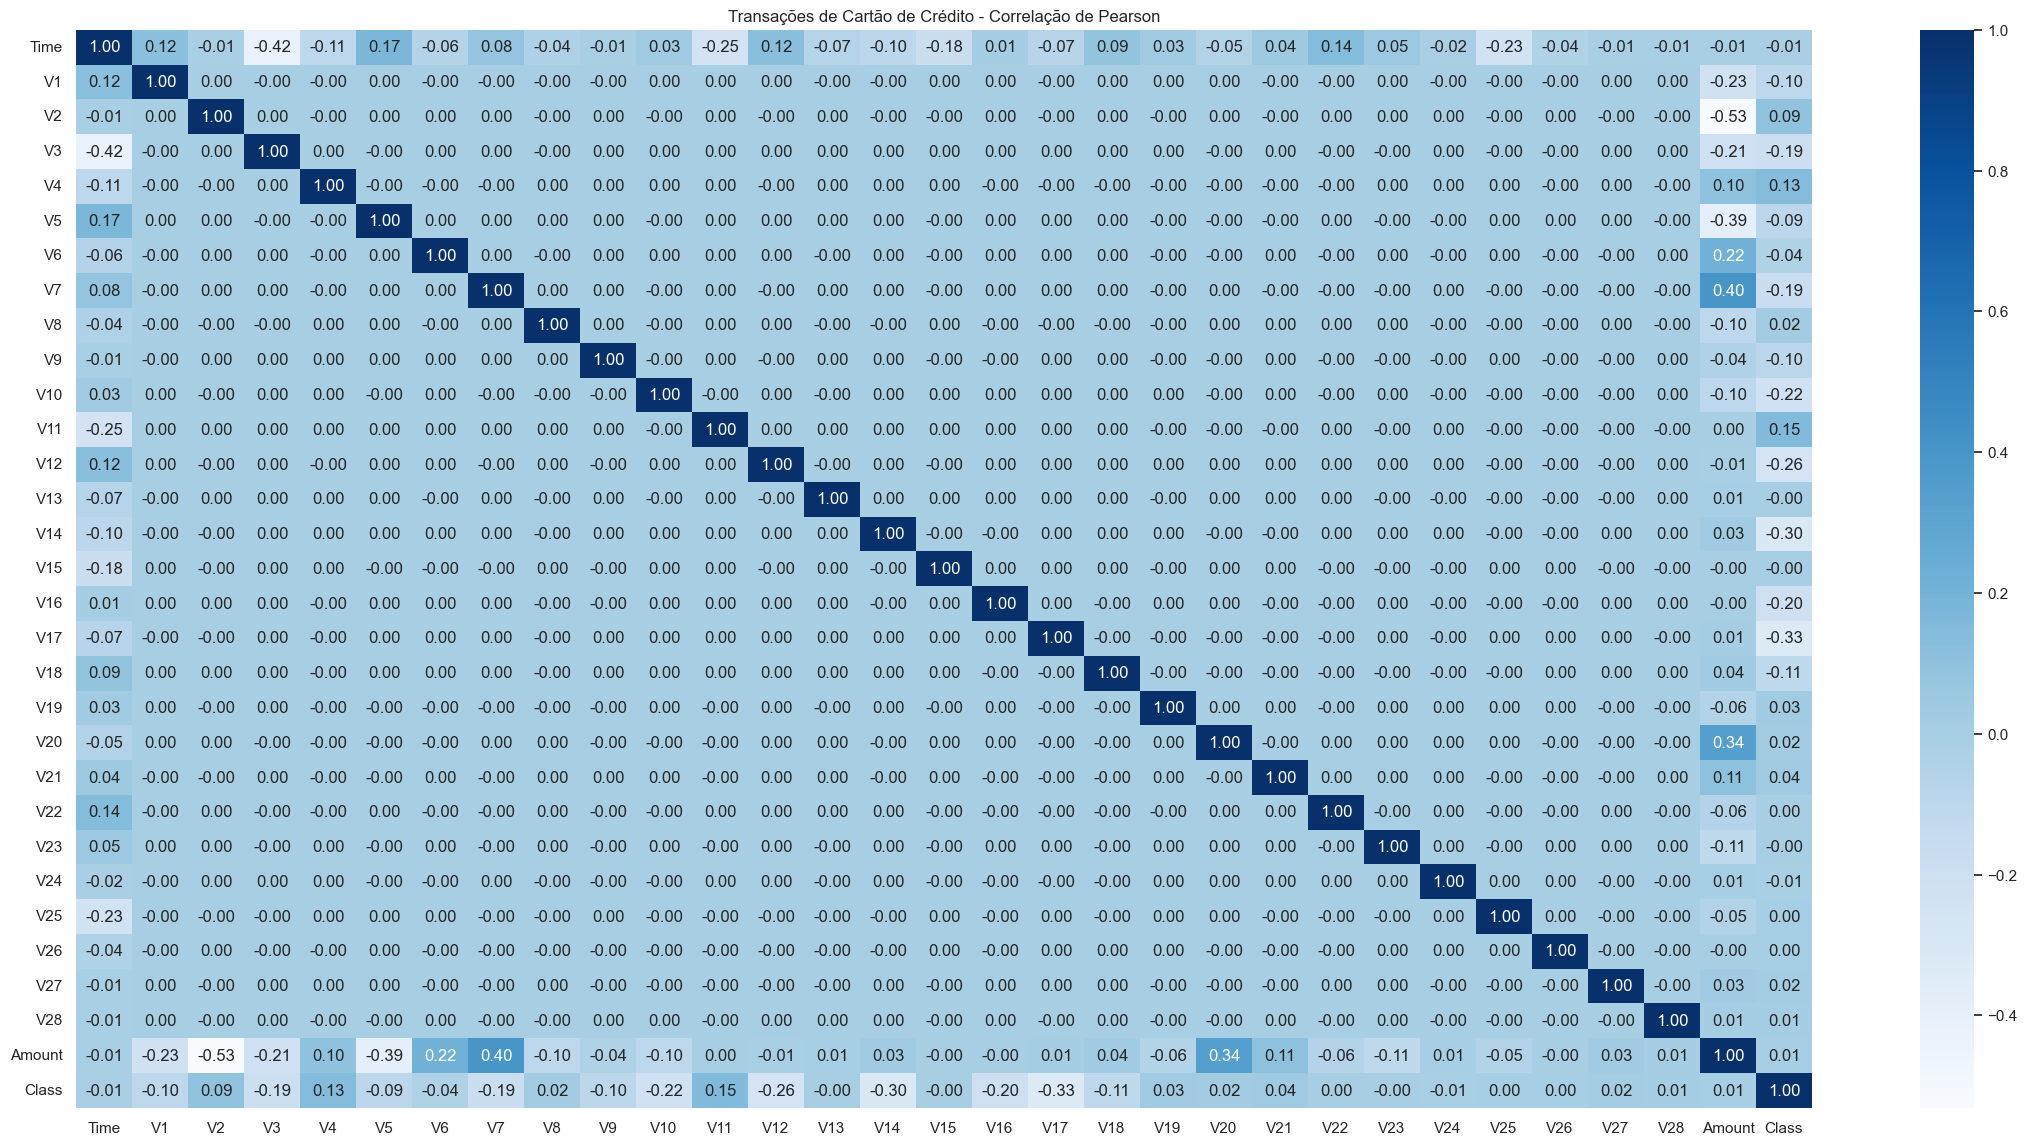

In [22]:
# Correlação de Pearson - Heatmap:
sns.set(rc={'figure.figsize':(28,14)}) # reajustar o fugsize

correlation = df2.corr(method='pearson')

sns.heatmap(correlation, annot=True, fmt='.2f', cmap="Blues").set_title('Transações de Cartão de Crédito - Correlação de Pearson');


# 4.0 DATA PREPARATION




**Observação:**
Nesta primeira etapa do CRISP-DM vamos simplesmente aplicar um modelo, sem uma maior preparação dos dados (Transformação, Reescalar e normalização dos dados) e não seremos tão rígidos com a seleção de features, embora essas etapas sejam essenciais, o primeiro objetivo é elaborar um modelo de ML capaz de agregar valor negócio, considerando o impacto econômico que pode ser agregado ao negócio.

In [23]:
# Criar uma cópia do DF:
df3= df2.copy()

In [24]:
# Separar os dados entre treinamento e teste:

x = df3.drop("Class", axis = 1)

y = df3["Class"]

# Separando entre treinamento e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 42, shuffle=True)

# 5.0 MACHINE LEARNING MODEL - ISOLATION FOREST APPLICATION

In [25]:
# Instanciar o modelo:
model_if1 = IsolationForest(n_estimators = 200, max_samples = len(x), random_state = 42)

# Treinar o modelo:
model_if1.fit(x_train)

IsolationForest(max_samples=284807, n_estimators=200, random_state=42)

In [27]:
# Realiza as predições para o conjunto de dados treino e teste:

y_pred_train1 = model_if1.predict(x_train)

y_pred_test1 = model_if1.predict(x_test)

In [28]:
# Conforme a documentação o retorno da IF -1 outliers e 1 inlier, fazer um ajuste conforme a classe:    
y_pred_train1 = np.where(y_pred_train1 == -1, 1, 0)
y_pred_test1 = np.where(y_pred_test1 == -1, 1, 0)

 # Referência: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [36]:
# print dos totais nos dados de treino:
print(f'Para os dados de treinamento foram preditas {np.count_nonzero(y_pred_train1 == 1)} fraudes')

print(f'Para os dados de treinamento existem {np.count_nonzero(y_train == 1)} fraudes')

Para os dados de treinamento foram preditas 331 fraudes

Para os dados de treinamento existem 246 fraudes


In [39]:
# print dos totais nos dados de teste:
print(f'Para os dados de teste foram previstas {np.count_nonzero(y_pred_test1 == 1)} fraudes')

print(f'\nPara os dados de teste existem {np.count_nonzero(y_test == 1)} fraudes')

Para os dados de teste foram previstas 320 fraudes

Para os dados de teste existem 246 fraudes
